# FDS Challenge Notebook

# 1. Preload functions

### Import libraries

In [22]:
import json
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from xgboost import XGBClassifier, plot_importance
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

### Load Data

In [23]:
# Function to load data from a JSONL file
def load_data(file_path: str) -> list:
    data = []
    print(f"Loading data from '{file_path}'...")
    try:
        with open(file_path, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        print(f"Successfully loaded {len(data)} battles.")
    except FileNotFoundError:
        print(f"ERROR: Could not find the file at '{file_path}'.")
    return data

### Extract datas

In [24]:
# Extract unique Pokémon with base stats
def extract_pokemon_no_ids(jsonl_path: str) -> pd.DataFrame:
    """
    Extracts a clean list of unique Pokémon with full base stats from the dataset.
    - Includes Pokémon from p1_team_details, p2_lead_details, and p2_pokemon_state.
    - Removes rows with all-zero stats if the Pokémon appears elsewhere with valid stats.
    - Removes duplicates across battles: only one row per Pokémon name.
    - Drops battle_id column.
    """
    rows = []

    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            battle = json.loads(line)

            # p1 team Pokémon
            for p in battle.get("p1_team_details", []):
                rows.append({
                    "name": p.get("name", "unknown"),
                    "base_hp": p.get("base_hp", 0),
                    "base_atk": p.get("base_atk", 0),
                    "base_def": p.get("base_def", 0),
                    "base_spa": p.get("base_spa", 0),
                    "base_spd": p.get("base_spd", 0),
                    "base_spe": p.get("base_spe", 0),
                    "type_1": p.get("types", "notype")[0],
                    "type_2": p.get("types", "notype")[1],
                    "lvl": p.get("level", 0),
                })

            # p2 lead details
            lead_details = battle.get("p2_lead_details")
            if lead_details:
                rows.append({
                    "name": lead_details.get("name", "unknown"),
                    "base_hp": lead_details.get("base_hp", 0),
                    "base_atk": lead_details.get("base_atk", 0),
                    "base_def": lead_details.get("base_def", 0),
                    "base_spa": lead_details.get("base_spa", 0),
                    "base_spd": lead_details.get("base_spd", 0),
                    "base_spe": lead_details.get("base_spe", 0),
                    "type_1": lead_details.get("types", "notype")[0],
                    "type_2": lead_details.get("types", "notype")[1],
                    "lvl": lead_details.get("level", 0),
                })

    df = pd.DataFrame(rows)

    # Remove zero-stat rows if name appears elsewhere with valid stats
    stat_cols = ["base_hp", "base_atk", "base_def", "base_spa", "base_spd", "base_spe", "lvl"]
    zero_mask = (df[stat_cols] == 0).all(axis=1)
    df = df.loc[~zero_mask]

    # Drop duplicates: keep only one row per Pokémon name
    df = df.drop_duplicates(subset=["name", "lvl"]).sort_values("lvl", ascending=False).reset_index(drop=True)

    return df


# Extract moves into a DataFrame
def extract_moves_df(jsonl_path: str) -> pd.DataFrame:
    """Extracts all moves from all battles into a long DataFrame."""
    move_rows = []

    # Read the JSONL file line by line
    with open(jsonl_path, "r", encoding="utf-8") as f:
        for line in f:
            battle = json.loads(line)
            battle_id = battle.get("battle_id")
            for turn_index, turn in enumerate(battle.get("battle_timeline", [])):
                for side in ["p1", "p2"]:
                    move = turn.get(f"{side}_move_details")
                    pokemon_state = turn.get(f"{side}_pokemon_state")
                    
                    # Only add if move and pokemon_state are not NaN
                    if move and pokemon_state:
                        move_rows.append({
                            "battle_id": battle_id, "player": side, "turn": turn_index,
                            "user_name": pokemon_state.get("name"),
                            "name": move.get("name"),
                            "type": move.get("type", "unknown").lower(),
                            "category": move.get("category", "unknown").lower(),
                            "base_power": move.get("base_power"),
                            "accuracy": move.get("accuracy"),
                            "priority": move.get("priority")
                        })
    moves_df = pd.DataFrame(move_rows)
    moves_df["name"] = moves_df["name"].str.lower().str.strip()
    return moves_df


# Get in-play teams 
def get_in_play_teams(battle_dict: dict, full_pokemon_db: dict, unique_pokemon_db: dict) -> tuple:
    """
    Gets P1's FULL known team and P2's SEEN team.
    """
    
    # P1: Get the full 6-Pokémon team from p1_team_details
    p1_pokemon = set()
    for pokemon in battle_dict.get("p1_team_details", []):
        if pokemon.get("name") and pokemon.get("level"):
            p1_pokemon.add((pokemon["name"].strip().lower(), pokemon["level"]))
    
    # P2: Add the lead Pokémon
    p2_lead = set()
    lead_details = battle_dict.get("p2_lead_details")
    if lead_details and lead_details.get("name") and lead_details.get("level"):
        p2_lead.add((lead_details["name"].strip().lower(), lead_details["level"]))
        
    # Add all both Pokémon from the timeline
    p2_sub = set()
    for turn in battle_dict.get("battle_timeline", []):
        if turn.get('p2_pokemon_state') and turn['p2_pokemon_state'].get('name'):
            p2_sub.add(turn['p2_pokemon_state']['name'])
    
    # Get their stats
    p1_team_list = [
        {**full_pokemon_db[(name, level)].copy(), "name": name, "level": level}
        for name, level in p1_pokemon if (name, level) in full_pokemon_db
    ]
    p2_lead_list = [
        {**full_pokemon_db[(name, level)].copy(), "name": name, "level": level}
        for name, level in p2_lead if (name, level) in full_pokemon_db
    ]
    p2_sub_list = [unique_pokemon_db[name].copy() for name in p2_sub if name in unique_pokemon_db]
    p2_team_list = p2_lead_list + p2_sub_list
    
    return p1_team_list, p2_team_list

### Pokémon type

In [25]:
# Gen 1 Type Chart: {AttackingType: {super_effective: [], not_very_effective: [], immune: []}}
TYPE_CHART = {
    "normal": {"not_very_effective": ["rock"], "immune": ["ghost"]},
    "fire": {"super_effective": ["grass", "ice", "bug"], "not_very_effective": ["fire", "water", "rock", "dragon"]},
    "water": {"super_effective": ["fire", "ground", "rock"], "not_very_effective": ["water", "grass", "dragon"]},
    "electric": {"super_effective": ["water", "flying"], "not_very_effective": ["electric", "grass", "dragon"], "immune": ["ground"]},
    "grass": {"super_effective": ["water", "ground", "rock"], "not_very_effective": ["fire", "grass", "poison", "flying", "bug", "dragon"]},
    "ice": {"super_effective": ["grass", "ground", "flying", "dragon"], "not_very_effective": ["fire", "water", "ice"]},
    "fighting": {"super_effective": ["normal", "ice", "rock"], "not_very_effective": ["poison", "flying", "psychic", "bug"], "immune": ["ghost"]},
    "poison": {"super_effective": ["grass"], "not_very_effective": ["poison", "ground", "rock", "ghost"]},
    "ground": {"super_effective": ["fire", "electric", "poison", "rock"], "not_very_effective": ["grass", "bug"], "immune": ["flying"]},
    "flying": {"super_effective": ["grass", "fighting", "bug"], "not_very_effective": ["electric", "rock"]},
    "psychic": {"super_effective": ["fighting", "poison"], "not_very_effective": ["psychic"], "immune": ["ghost"]},
    "bug": {"super_effective": ["grass", "poison"], "not_very_effective": ["fire", "fighting", "flying", "ghost", "psychic"]},
    "rock": {"super_effective": ["fire", "ice", "flying", "bug"], "not_very_effective": ["fighting", "ground"]},
    "ghost": {"super_effective": ["ghost"], "not_very_effective": [], "immune": ["normal"]},
    "dragon": {"super_effective": ["dragon"], "not_very_effective": []},
    "notype": {}
}


# Calculate type effectiveness
def calculate_type_effectiveness(attack_type: str, defend_types: list[str]) -> float:
    """Calculates the effectiveness multiplier for one attack."""
    # 'notype' case
    if attack_type == "notype": return 1.0
    
    # Initialize multiplier
    multiplier = 1.0
    chart = TYPE_CHART.get(attack_type, {})
    
    # Check defending types
    for def_type in defend_types:
        
        # Change multiplier based on effectiveness
        if def_type == "notype": continue   
        if def_type in chart.get("super_effective", []):
            multiplier *= 2.0
        if def_type in chart.get("not_very_effective", []):
            multiplier *= 0.5
        if def_type in chart.get("immune", []):
            return 0.0
    return multiplier


# Calculate team type advantage
def calculate_team_advantage(team1, team2):
    """
    Calculates a simple type advantage score for Team 1 vs Team 2.
    Uses the *magnitude* of the advantage, not just a +1/-1 score.
    """
    if not team1 or not team2:
        return 0

    score = 0
    for p1 in team1:
        p1_types = [p1.get('type_1', 'notype'), p1.get('type_2', 'notype')]
        
        for p2 in team2:
            p2_types = [p2.get('type_1', 'notype'), p2.get('type_2', 'notype')]
            
            # How well does P1 attack P2? (Use max of its two types)
            p1_adv = max(calculate_type_effectiveness(p1_types[0], p2_types), 
                         calculate_type_effectiveness(p1_types[1], p2_types))
            
            # How well does P2 attack P1? (Use max of its two types)
            p2_adv = max(calculate_type_effectiveness(p2_types[0], p1_types), 
                         calculate_type_effectiveness(p2_types[1], p1_types))

            # A 2x vs 0.5x adv is a +1.5 score for this matchup.
            # A 1x vs 1x adv is a 0 score.
            # A 0.5x vs 4x adv is a -3.5 score.
            score += (p1_adv - p2_adv)
            
    # Normalize score by number of matchups
    return score / (len(team1) * len(team2))

### Stat scaling

In [26]:
# Gen 1 single statistic scaler
def gen1_stat_scaler(base: int, lvl: int, hp_bool: bool) -> float:
    """
    Official Gen 1 formula for all other stats (Atk, Def, SpA, SpD, Spe):
    HP = ((base_hp + DV) * 2 + sqrt(EV)//4) * Level / 100 + Level + 10
    Stat = ((base_stat + DV) * 2 + sqrt(EV)//4) * Level / 100 + 5
    """
    # We assume that in competitive play, all Pokémon have maximum DVs and EVs.
    max_DVs = 15        # Determinant Values
    max_EVs = 65535     # Effort Values 
    square_term = np.sqrt(max_EVs) / 4

    if hp_bool:
        return ((base + max_DVs) * 2 + square_term) * lvl // 100 + lvl + 10
    return ((base + max_DVs) * 2 + square_term) * lvl // 100 + 5


# Scale stats for all Pokémon in the DataFrame
def gen1_scaler(df:pd.DataFrame) -> pd.DataFrame:
    """
    Scales Pokémon stats according to their level using official Gen 1 formulas.
    Source: https://bulbapedia.bulbagarden.net/wiki/Stat
    """

    df = df.copy()
    # Scaling Pokémon stats basing on their level
    df["hp"] = df.apply(lambda x: gen1_stat_scaler(x["base_hp"], x["lvl"], True), axis=1)
    df["atk"] = df.apply(lambda x: gen1_stat_scaler(x["base_atk"], x["lvl"], False), axis=1)
    df["def"] = df.apply(lambda x: gen1_stat_scaler(x["base_def"], x["lvl"], False), axis=1)
    df["spa"] = df.apply(lambda x: gen1_stat_scaler(x["base_spa"], x["lvl"], False), axis=1)
    df["spd"] = df.apply(lambda x: gen1_stat_scaler(x["base_spd"], x["lvl"], False), axis=1)
    df["spe"] = df.apply(lambda x: gen1_stat_scaler(x["base_spe"], x["lvl"], False), axis=1)

    # Drop base stat columns
    df = df.drop(columns=[
        "base_hp", "base_atk", "base_def", "base_spa", "base_spd", "base_spe"
    ])

    return df


# Calculate mean scaled stats per Pokémon name
def gen1_mean_stats(scaled_df:pd.DataFrame, unique_pokemon_df:pd.DataFrame) -> pd.DataFrame:
    """
    Calculates mean scaled stats per Pokémon name, used when level data is missing.
    """
    # Compute mean stats
    cols = ["lvl","hp","atk","def","spa","spd","spe"]
    mean_stats = (
        scaled_df[["name", *cols]]
        .groupby("name", as_index=False)
        .mean()
    )

    # Normalize and merge with types
    mean_stats[cols] = mean_stats[cols].round().astype("float32")
    mean_pokemon_df = mean_stats.merge(
        unique_pokemon_df[["name", "type_1", "type_2"]],
        on="name",
        how="left"
    )
    return mean_pokemon_df

### Feature extracting

In [27]:
# Create move features at battle level
def create_move_features(moves_df: pd.DataFrame, pokemon_db: dict) -> pd.DataFrame:
    """
    Aggregates move data to the battle level, focusing on
    STAB, coverage, and GAME-WINNING move types.
    """
    
    # Define Key Move Sets
    SLEEP_MOVES = {'sleep powder', 'hypnosis', 'spore', 'lovely kiss', 'sing'}
    PARA_MOVES = {'thunder wave', 'stun spore', 'glare'}
    SETUP_MOVES = {'swords dance', 'amnesia', 'agility', 'double-team'}
    RECOVERY_MOVES = {'recover', 'soft-boiled'}
    
    # Calculate STAB
    stab_rows = []
    for _, row in moves_df.iterrows():
        is_stab = 0
        user = pokemon_db.get(row['user_name'])
        if user:
            user_types = [user.get('type_1'), user.get('type_2')]
            if row['type'] in user_types:
                is_stab = 1
        stab_rows.append(is_stab)
    moves_df['is_stab'] = stab_rows
    
    # Get move names for filtering
    moves_df['move_name'] = moves_df['name'].str.lower().str.strip()

    p1_moves = moves_df[moves_df['player'] == 'p1'].copy()
    p2_moves = moves_df[moves_df['player'] == 'p2'].copy()
    
    # Aggregate P1
    p1_gb = p1_moves.groupby('battle_id')
    p1_status_moves = p1_moves[p1_moves['category'] == 'status'].groupby('battle_id').size().rename('p1_status_count')
    p1_priority_moves = p1_moves[p1_moves['priority'] > 0].groupby('battle_id').size().rename('p1_priority_count')
    p1_stab_count = p1_moves[p1_moves['is_stab'] == 1].groupby('battle_id').size().rename('p1_stab_count')
    p1_coverage = p1_gb['type'].nunique().rename('p1_coverage_types')
    p1_avg_power_stab = p1_moves[p1_moves['is_stab'] == 1].groupby('battle_id')['base_power'].mean().rename('p1_avg_power_stab')

    # P1 Key Move Counts
    p1_sleep_moves = p1_moves[p1_moves['move_name'].isin(SLEEP_MOVES)].groupby('battle_id').size().rename('p1_sleep_move_count')
    p1_para_moves = p1_moves[p1_moves['move_name'].isin(PARA_MOVES)].groupby('battle_id').size().rename('p1_para_move_count')
    p1_setup_moves = p1_moves[p1_moves['move_name'].isin(SETUP_MOVES)].groupby('battle_id').size().rename('p1_setup_move_count')
    p1_recovery_moves = p1_moves[p1_moves['move_name'].isin(RECOVERY_MOVES)].groupby('battle_id').size().rename('p1_recovery_move_count')

    # Aggregate P2
    p2_gb = p2_moves.groupby('battle_id')
    p2_status_moves = p2_moves[p2_moves['category'] == 'status'].groupby('battle_id').size().rename('p2_status_count')
    p2_priority_moves = p2_moves[p2_moves['priority'] > 0].groupby('battle_id').size().rename('p2_priority_count')
    p2_stab_count = p2_moves[p2_moves['is_stab'] == 1].groupby('battle_id').size().rename('p2_stab_count')
    p2_coverage = p2_gb['type'].nunique().rename('p2_coverage_types')
    p2_avg_power_stab = p2_moves[p2_moves['is_stab'] == 1].groupby('battle_id')['base_power'].mean().rename('p2_avg_power_stab')

    # P2 Key Move Counts
    p2_sleep_moves = p2_moves[p2_moves['move_name'].isin(SLEEP_MOVES)].groupby('battle_id').size().rename('p2_sleep_move_count')
    p2_para_moves = p2_moves[p2_moves['move_name'].isin(PARA_MOVES)].groupby('battle_id').size().rename('p2_para_move_count') # <-- BUG FIX
    p2_setup_moves = p2_moves[p2_moves['move_name'].isin(SETUP_MOVES)].groupby('battle_id').size().rename('p2_setup_move_count')
    p2_recovery_moves = p2_moves[p2_moves['move_name'].isin(RECOVERY_MOVES)].groupby('battle_id').size().rename('p2_recovery_move_count')


    # Combine all features
    aggregated_features = pd.concat([
        p1_status_moves, p2_status_moves,
        p1_priority_moves, p2_priority_moves,
        p1_stab_count, p2_stab_count,
        p1_coverage, p2_coverage,
        p1_avg_power_stab, p2_avg_power_stab,
        
        # Adding the new features
        p1_sleep_moves, p2_sleep_moves,
        p1_para_moves, p2_para_moves,
        p1_setup_moves, p2_setup_moves,
        p1_recovery_moves, p2_recovery_moves
        
    ], axis=1).fillna(0)
    
    # Add new diffs
    aggregated_features['diff_status_count'] = aggregated_features['p1_status_count'] - aggregated_features['p2_status_count']
    aggregated_features['diff_stab_count'] = aggregated_features['p1_stab_count'] - aggregated_features['p2_stab_count']
    aggregated_features['diff_coverage_types'] = aggregated_features['p1_coverage_types'] - aggregated_features['p2_coverage_types']
    aggregated_features['diff_avg_power_stab'] = aggregated_features['p1_avg_power_stab'] - aggregated_features['p2_avg_power_stab']
    
    # Add Key Move Diffs
    aggregated_features['diff_sleep_move_count'] = aggregated_features['p1_sleep_move_count'] - aggregated_features['p2_sleep_move_count']
    aggregated_features['diff_para_move_count'] = aggregated_features['p1_para_move_count'] - aggregated_features['p2_para_move_count']
    aggregated_features['diff_setup_move_count'] = aggregated_features['p1_setup_move_count'] - aggregated_features['p2_setup_move_count']
    aggregated_features['diff_recovery_move_count'] = aggregated_features['p1_recovery_move_count'] - aggregated_features['p2_recovery_move_count']
    
    return aggregated_features


# Get team aggregate stats
def get_team_aggregate_stats(team_list: list) -> dict:
    """Calculates aggregate and max stats for a given team list."""
    if not team_list:
        # Return a zeroed-out dict to prevent errors
        stats = ['hp', 'atk', 'def', 'spa', 'spd', 'spe']
        zero_stats = {f'avg_{s}': 0 for s in stats}
        zero_stats.update({f'max_{s}': 0 for s in stats})
        zero_stats['team_size'] = 0
        zero_stats['top_tier_count'] = 0
        zero_stats['avg_phys_bulk'] = 0
        zero_stats['avg_spec_bulk'] = 0
        return zero_stats

    num_pokemon = len(team_list)
    
    # Define the Gen 1 "Big Guns"
    # These are the Pokémon that warp the metagame
    TOP_TIER_MONS = {
        "Snorlax", "Chansey", "Tauros", "Alakazam", 
        "Exeggutor", "Starmie", "Gengar", "Lapras", "Zapdos"
    }
    
    # AVG Stats
    stats = {}
    stats['avg_hp']  = sum(p.get('hp', 0) for p in team_list) / num_pokemon
    stats['avg_atk'] = sum(p.get('atk', 0) for p in team_list) / num_pokemon
    stats['avg_def'] = sum(p.get('def', 0) for p in team_list) / num_pokemon
    stats['avg_spa'] = sum(p.get('spa', 0) for p in team_list) / num_pokemon
    stats['avg_spd'] = sum(p.get('spd', 0) for p in team_list) / num_pokemon
    stats['avg_spe'] = sum(p.get('spe', 0) for p in team_list) / num_pokemon
    
    # Max Stats
    stats['max_hp']  = max(p.get('hp', 0) for p in team_list)
    stats['max_atk'] = max(p.get('atk', 0) for p in team_list)
    stats['max_def'] = max(p.get('def', 0) for p in team_list)
    stats['max_spa'] = max(p.get('spa', 0) for p in team_list)
    stats['max_spd'] = max(p.get('spd', 0) for p in team_list)
    stats['max_spe'] = max(p.get('spe', 0) for p in team_list)

    # Bulk Proxies (Gen 1 used one "Special" stat, but data has SpA/SpD)
    # We'll use SpD for special bulk.
    stats['avg_phys_bulk'] = stats['avg_hp'] * stats['avg_def']
    stats['avg_spec_bulk'] = stats['avg_hp'] * stats['avg_spd']
    
    # Meta-Defining Pokémon Count
    stats['top_tier_count'] = sum(1 for p in team_list if p.get('name') in TOP_TIER_MONS)
    
    stats['team_size'] = num_pokemon
    return stats


# Create feature DataFrame from raw data
def create_feature_dataframe(raw_data_list: list, full_pokemon_db: dict, unique_pokemon_db: dict, move_features_df: pd.DataFrame) -> pd.DataFrame:
    """
    Takes the raw battle data (as a list of dicts) and creates the 
    final feature DataFrame based on IN-PLAY pokemon AND BATTLE DYNAMICS.
    
    --- THIS IS THE FINAL, CORRECTED FUNCTION ---
    """
    flattened_data = []
    
    stat_keys = [
        'avg_hp', 'avg_atk', 'avg_def', 'avg_spa', 'avg_spd', 'avg_spe',
        'max_hp', 'max_atk', 'max_def', 'max_spa', 'max_spd', 'max_spe',
        'avg_phys_bulk', 'avg_spec_bulk', 'top_tier_count'
    ]

    for battle in raw_data_list:
        
        # Get In-Play Teams
        p1_in_play_team, p2_in_play_team = get_in_play_teams(battle, full_pokemon_db, unique_pokemon_db)
        
        # Get Team Aggregate Stats
        p1_stats = get_team_aggregate_stats(p1_in_play_team)
        p2_stats = get_team_aggregate_stats(p2_in_play_team)

        # Get Lead Matchup Features
        p1_lead_name = battle.get("p1_team_details", [{}])[0].get("name")
        p2_lead_name = battle.get("p2_lead_details", {}).get("name")
        p1_lead_stats = full_pokemon_db.get(p1_lead_name)
        p2_lead_stats = full_pokemon_db.get(p2_lead_name)
        
        lead_speed_diff = 0
        lead_type_adv = 0
        lead_offense_diff = 0
        if p1_lead_stats and p2_lead_stats:
            lead_speed_diff = p1_lead_stats.get('base_spe', 0) - p2_lead_stats.get('base_spe', 0)
            lead_type_adv = calculate_team_advantage([p1_lead_stats], [p2_lead_stats])
            p1_lead_offense = max(p1_lead_stats.get('base_atk', 0), p1_lead_stats.get('base_spa', 0))
            p2_lead_offense = max(p2_lead_stats.get('base_atk', 0), p2_lead_stats.get('base_spa', 0))
            lead_offense_diff = p1_lead_offense - p2_lead_offense
            
        # Build the feature row
        row = {'battle_id': battle.get('battle_id')}

        if 'player_won' in battle:
            row['target_p1_won'] = 1 if battle.get('player_won') else 0

        # Add Static Stat Features
        for key in stat_keys:
            p1_val = p1_stats.get(key, 0)
            p2_val = p2_stats.get(key, 0)
            row[f'p1_{key}'] = p1_val
            row[f'p2_{key}'] = p2_val
            row[f'diff_{key}'] = p1_val - p2_val 

        row['diff_team_size'] = p1_stats['team_size'] - p2_stats['team_size']
        row['diff_type_adv'] = calculate_team_advantage(p1_in_play_team, p2_in_play_team)
        row['lead_speed_diff'] = lead_speed_diff
        row['lead_type_adv'] = lead_type_adv
        row['lead_offense_diff'] = lead_offense_diff
        
        # Initialize State Dictionaries, these will hold the *last known state*
        p1_team_state = {}
        p2_team_state = {}
        
        # Pre-fill P1's full team
        for p in battle.get("p1_team_details", []):
            if p.get("name"):
                p1_team_state[p["name"]] = {
                    "hp_pct": 1, 
                    "status": None, 
                    "stat_stages": {}
                }
        
        # Initialize counters
        p1_switches = 0
        p2_switches = 0
        p1_fainted_names = set() # KOs by P2
        p2_fainted_names = set() # KOs by P1
        
        battle_timeline = battle.get("battle_timeline", [])
        num_turns = len(battle_timeline)
        
        # Loop Timeline to Update State
        for turn in battle_timeline:

            # P1 State Update
            p1_state_json = turn.get("p1_pokemon_state")
            if p1_state_json and p1_state_json.get("name"):
                name = p1_state_json["name"]
                
                # Create P1 entry if somehow missed (e.g., Zoroark)
                if name not in p1_team_state: 
                     print(f"Warning: P1 Pokémon '{name}' not in team state. Adding dynamically.")
                     p1_team_state[name] = {"hp_pct": 100, "status": None, "stat_stages": {}}
                
                # Corrected "Sticky" Logic
                # HP and Stats are always overwritten with the latest
                p1_team_state[name]["hp_pct"] = p1_state_json.get("hp_pct", p1_team_state[name]["hp_pct"]) * 100
                p1_team_state[name]["stat_stages"] = p1_state_json.get("stat_stages", {})

                # Status is STICKY. Only update if it's not None.
                if p1_state_json.get("status") is not None:
                    p1_team_state[name]["status"] = p1_state_json.get("status")
                
                # Fainted is STICKY. Use your original set logic.
                if p1_state_json.get("fainted") and name not in p1_fainted_names:
                    p1_fainted_names.add(name)
                
            # P2 State Update
            p2_state_json = turn.get("p2_pokemon_state")
            if p2_state_json and p2_state_json.get("name"):
                name = p2_state_json["name"]
                
                # Update/Create P2 state
                if name not in p2_team_state:
                    p2_team_state[name] = {"hp_pct": 100, "status": None, "stat_stages": {}}
                
                # Corrected "Sticky" Logic
                p2_team_state[name]["hp_pct"] = p2_state_json.get("hp_pct", p2_team_state[name]["hp_pct"]) * 100
                p2_team_state[name]["stat_stages"] = p2_state_json.get("stat_stages", {})

                if p2_state_json.get("status") is not None:
                    p2_team_state[name]["status"] = p2_state_json.get("status")

                if p2_state_json.get("fainted") and name not in p2_fainted_names:
                    p2_fainted_names.add(name)
                
            # Switch Counting (Your existing logic)
            if not turn.get("p1_move_details") and p1_state_json and not p1_state_json.get("fainted"):
                p1_switches += 1
            if not turn.get("p2_move_details") and p2_state_json and not p2_state_json.get("fainted"):
                p2_switches += 1

        # Aggregate Final State Features
        # HP Features: get HP of all mons that are NOT in the fainted set
        p1_hp_list = [
            s["hp_pct"] for name, s in p1_team_state.items() 
            if name not in p1_fainted_names
        ]
        p2_hp_list = [
            s["hp_pct"] for name, s in p2_team_state.items() 
            if name not in p2_fainted_names
        ]

        row['p1_avg_hp'] = sum(p1_hp_list) / len(p1_hp_list) if p1_hp_list else 0
        row['p2_avg_hp'] = sum(p2_hp_list) / len(p2_hp_list) if p2_hp_list else 0
        row['diff_avg_hp'] = row['p1_avg_hp'] - row['p2_avg_hp']

        row['p1_total_hp'] = sum(p1_hp_list)
        row['p2_total_hp'] = sum(p2_hp_list)
        row['diff_total_hp'] = row['p1_total_hp'] - row['p2_total_hp']

        # Status Features: get status of all mons that are NOT in the fainted set
        p1_status_counts = {"par": 0, "slp": 0, "frz": 0, "psn": 0, "brn": 0}
        for name, s in p1_team_state.items():
            if name not in p1_fainted_names and s["status"] in p1_status_counts:
                p1_status_counts[s["status"]] += 1
            
        p2_status_counts = {"par": 0, "slp": 0, "frz": 0, "psn": 0, "brn": 0}
        for name, s in p2_team_state.items():
            if name not in p2_fainted_names and s["status"] in p2_status_counts:
                p2_status_counts[s["status"]] += 1
            
        row['p1_paralyzed'] = p1_status_counts['par']
        row['p2_paralyzed'] = p2_status_counts['par']
        row['diff_paralyzed'] = row['p1_paralyzed'] - row['p2_paralyzed']
        
        row['p1_asleep'] = p1_status_counts['slp']
        row['p2_asleep'] = p2_status_counts['slp']
        row['diff_asleep'] = row['p1_asleep'] - row['p2_asleep']

        row['p1_frozen'] = p1_status_counts['frz'] # This is a HUGE signal
        row['p2_frozen'] = p2_status_counts['frz']
        row['diff_frozen'] = row['p1_frozen'] - row['p2_frozen']
        
        # Fainted & Active Mon Features
        p1_fainted_count = len(p1_fainted_names)
        p2_fainted_count = len(p2_fainted_names)
        
        row['p1_fainted'] = p1_fainted_count # KOs by P2
        row['p2_fainted'] = p2_fainted_count # KOs by P1
        row['diff_fainted'] = row['p1_fainted'] - row['p2_fainted'] # Negative is good for P1
        
        row['p1_active_mons'] = 6 - p1_fainted_count
        row['p2_active_mons'] = len(p2_team_state) - p2_fainted_count # Based on *seen* mons
        row['diff_active_mons'] = row['p1_active_mons'] - row['p2_active_mons']
        
        # Stat Boost Features
        p1_net_boosts = 0
        for name, s in p1_team_state.items():
            if name not in p1_fainted_names:
                p1_net_boosts += sum(v for v in s.get("stat_stages", {}).values())

        p2_net_boosts = 0
        for name, s in p2_team_state.items():
            if name not in p2_fainted_names:
                p2_net_boosts += sum(v for v in s.get("stat_stages", {}).values())

        row['p1_net_boosts'] = p1_net_boosts
        row['p2_net_boosts'] = p2_net_boosts
        row['diff_net_boosts'] = row['p1_net_boosts'] - row['p2_net_boosts']
        
        # Flow Features
        row['num_turns'] = num_turns
        row['p1_switches'] = p1_switches
        row['p2_switches'] = p2_switches
        row['diff_switches'] = p1_switches - p2_switches
        flattened_data.append(row)

    # Convert to DataFrame
    df_features = pd.DataFrame(flattened_data)
    
    # Merge Move Features
    df_features = df_features.merge(move_features_df, on='battle_id', how='left')
    df_features = df_features.fillna(0)
    
    return df_features

# 2. Prepare datas

### Build pokemon dtaframe and databases

In [28]:
# Define the path to our data 
COMPETITION_NAME = 'fds-pokemon-battles-prediction-2025'
DATA_PATH = os.path.join('/kaggle/input', COMPETITION_NAME)
# train_file_path = os.path.join(DATA_PATH, 'train.jsonl')
# test_file_path = os.path.join(DATA_PATH, 'test.jsonl')
train_file_path = "C:\\Users\\Kevin\\Desktop\\Magistrale\\Pokemon-Battles-prediction\\data\\train.jsonl"
test_file_path = "C:\\Users\\Kevin\\Desktop\\Magistrale\\Pokemon-Battles-prediction\\test\\test.jsonl"


# Load Data
train_data = load_data(train_file_path)
test_data = load_data(test_file_path)
print(f"\nLoaded {len(train_data)} training battles and {len(test_data)} test battles.")


# Build the Pokémon DFs
pokemon_df_train = extract_pokemon_no_ids(train_file_path)
pokemon_df_test = extract_pokemon_no_ids(test_file_path)
print(f"\nFound {len(pokemon_df_train)} Pokémon in train data and {len(pokemon_df_test)} Pokémon in test data.")


# Combine them and de-duplicate
pokemon_full_df = pd.concat([pokemon_df_train, pokemon_df_test])

# Remove zero-stat rows if name appears elsewhere with valid stats
stat_cols = ["base_hp", "base_atk", "base_def", "base_spa", "base_spd", "base_spe"]
zero_mask = (pokemon_full_df[stat_cols] == 0).all(axis=1)
valid_names = set(pokemon_full_df.loc[~zero_mask, "name"])
pokemon_full_df = pokemon_full_df.loc[~(zero_mask & pokemon_full_df["name"].isin(valid_names))]
pokemon_full_df = pokemon_full_df.sort_values("lvl", ascending=False).reset_index(drop=True)
pokemon_full_df = pokemon_full_df.drop_duplicates(subset=["name", "lvl"], keep="first").reset_index(drop=True)
print(f"\nFull Pokémon DataFrame created with {len(pokemon_full_df)} entries")


# Scale Pokémon Stats with Level
pokemon_full_df_scaled = gen1_scaler(pokemon_full_df)
pokemon_full_db_scaled = pokemon_full_df_scaled.set_index(["name", "lvl"]).to_dict('index')
print(f"\nScaled Stats DataFrame created with {len(pokemon_full_df_scaled)} entries")
display(pokemon_full_df_scaled.head(3))

# Keep only one row per Pokémon name
unique_pokemon_df = pokemon_full_df.drop_duplicates(subset=["name"], keep="first").reset_index(drop=True)
unique_pokemon_scaled_df = gen1_scaler(unique_pokemon_df)
unique_pokemon_db = unique_pokemon_scaled_df.set_index('name').to_dict('index')
print(f"\nPokémon DF created with {len(unique_pokemon_db)} entries")
display(unique_pokemon_scaled_df.head(3))

# Compute mean stats between levels per Pokémon name
mean_unique_pokemon_df = gen1_mean_stats(pokemon_full_df_scaled, unique_pokemon_scaled_df)
mean_unique_pokemon_db = mean_unique_pokemon_df.set_index('name').to_dict('index')
print(f"\nMean Stats DataFrame created with {len(mean_unique_pokemon_df)} entries")
display(mean_unique_pokemon_df.head(3))

Loading data from 'C:\Users\Kevin\Desktop\Magistrale\Pokemon-Battles-prediction\data\train.jsonl'...
Successfully loaded 10000 battles.
Loading data from 'C:\Users\Kevin\Desktop\Magistrale\Pokemon-Battles-prediction\test\test.jsonl'...
Successfully loaded 5000 battles.

Loaded 10000 training battles and 5000 test battles.

Found 31 Pokémon in train data and 28 Pokémon in test data.

Full Pokémon DataFrame created with 35 entries

Scaled Stats DataFrame created with 35 entries


,name,type_1,type_2,lvl,hp,atk,def,spa,spd,spe
0,starmie,psychic,water,100,323.0,248.0,268.0,298.0,298.0,328.0
1,exeggutor,grass,psychic,100,393.0,288.0,268.0,348.0,348.0,208.0
2,chansey,normal,notype,100,703.0,108.0,108.0,308.0,308.0,198.0



Pokémon DF created with 20 entries


,name,type_1,type_2,lvl,hp,atk,def,spa,spd,spe
0,starmie,psychic,water,100,323.0,248.0,268.0,298.0,298.0,328.0
1,exeggutor,grass,psychic,100,393.0,288.0,268.0,348.0,348.0,208.0
2,chansey,normal,notype,100,703.0,108.0,108.0,308.0,308.0,198.0



Mean Stats DataFrame created with 20 entries


,name,lvl,hp,atk,def,spa,spd,spe,type_1,type_2
0,alakazam,78.0,245.0,154.0,147.0,286.0,286.0,263.0,notype,psychic
1,articuno,100.0,383.0,268.0,298.0,348.0,348.0,268.0,flying,ice
2,chansey,80.0,564.0,88.0,88.0,248.0,248.0,159.0,normal,notype


### Build move dataframes

In [29]:
# Build move dataframes
print("Building move dataframes...")
moves_df_train = extract_moves_df(train_file_path)
moves_df_test = extract_moves_df(test_file_path)

# Display results
print("\nFinal Training moves")
display(moves_df_train.head(3))

print("\nFinal Testing moves")
display(moves_df_test.head(3))

Building move dataframes...

Final Training moves


,battle_id,player,turn,user_name,name,type,category,base_power,accuracy,priority
0,0,p1,0,starmie,icebeam,ice,special,95,1.00,0
1,0,p1,2,exeggutor,sleeppowder,grass,status,0,0.75,0
2,0,p2,2,starmie,blizzard,ice,special,120,0.90,0



Final Testing moves


,battle_id,player,turn,user_name,name,type,category,base_power,accuracy,priority
0,0,p2,0,jolteon,thunderwave,electric,status,0,1.0,0
1,0,p1,2,chansey,thunderwave,electric,status,0,1.0,0
2,0,p1,3,chansey,icebeam,ice,special,95,1.0,0


# 3. Feature engeneering

In [30]:
# Create move features
print("\nProcessing move features...")
move_features_train = create_move_features(moves_df_train, unique_pokemon_db)
move_features_test = create_move_features(moves_df_test, unique_pokemon_db)


# Process both Train and Test data
print("\nProcessing training data...")
df_train_features = create_feature_dataframe(train_data, pokemon_full_db_scaled, mean_unique_pokemon_db, move_features_train)
print("\nProcessing test data...")
df_test_features = create_feature_dataframe(test_data, pokemon_full_db_scaled, mean_unique_pokemon_db, move_features_test)

# Display Results
print("\nFinal Training DataFrame")
display(df_train_features.head(3))

print("\nFinal Testing DataFrame")
display(df_test_features.head(3))


Processing move features...

Processing training data...

Processing test data...

Final Training DataFrame


,battle_id,target_p1_won,p1_avg_hp,p2_avg_hp,diff_avg_hp,p1_avg_atk,p2_avg_atk,diff_avg_atk,p1_avg_def,p2_avg_def,...,p1_recovery_move_count,p2_recovery_move_count,diff_status_count,diff_stab_count,diff_coverage_types,diff_avg_power_stab,diff_sleep_move_count,diff_para_move_count,diff_setup_move_count,diff_recovery_move_count
0,0,1,31.546900,16.187554,15.359345,243.000000,200.400000,42.600000,224.666667,190.400000,...,0.0,3.0,7.0,6.0,1.0,-41.000000,0.0,0.0,0.0,-3.0
1,1,1,26.333333,42.833333,-16.500000,243.000000,191.142857,51.857143,229.666667,177.571429,...,0.0,0.0,-1.0,6.0,0.0,18.250000,0.0,0.0,0.0,0.0
2,2,1,20.166667,54.000000,-33.833333,266.333333,144.200000,122.133333,241.333333,140.000000,...,0.0,5.0,6.0,11.0,1.0,40.909091,-2.0,0.0,8.0,-5.0



Final Testing DataFrame


,battle_id,p1_avg_hp,p2_avg_hp,diff_avg_hp,p1_avg_atk,p2_avg_atk,diff_avg_atk,p1_avg_def,p2_avg_def,diff_avg_def,...,p1_recovery_move_count,p2_recovery_move_count,diff_status_count,diff_stab_count,diff_coverage_types,diff_avg_power_stab,diff_sleep_move_count,diff_para_move_count,diff_setup_move_count,diff_recovery_move_count
0,0,16.833333,53.400000,-36.566667,246.333333,219.666667,26.666667,221.333333,190.000000,31.333333,...,0.0,0.0,-9.0,6.0,0.0,-5.197802,0.0,0.0,0.0,0.0
1,1,39.000000,64.666667,-25.666667,289.333333,232.571429,56.761905,291.333333,212.571429,78.761905,...,0.0,0.0,4.0,-7.0,1.0,-59.000000,0.0,0.0,0.0,0.0
2,2,63.879836,75.405604,-11.525768,279.666667,207.428571,72.238095,274.666667,215.571429,59.095238,...,0.0,0.0,0.0,-4.0,2.0,-45.000000,0.0,0.0,0.0,0.0


# 4. Model Traning

### Preparing datas

In [31]:
# Define X: features and y: target
X = df_train_features.drop(columns=["battle_id", "target_p1_won"])
y = df_train_features["target_p1_won"]

# Drop battle_id from test features
X_test = df_test_features.drop(columns=["battle_id"])
# Align columns just in case
X_test = X_test[X.columns] 

print(f"Training features shape: {X.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (10000, 101)
Test features shape: (5000, 101)


### Model 1: XGBoost

In [37]:
# Stratified K-Fold strategy
kfold_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define hyperparameter search space
param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [3, 4, 5, 6, 7],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "gamma": [0, 0.1, 0.2, 0.3],
    "reg_alpha": [0, 0.1, 0.5],
    "reg_lambda": [1, 1.5, 2, 3]
}

# Initialize XGBoost Classifier
xgb = XGBClassifier(eval_metric="logloss", random_state=42)

# Initialize RandomizedSearchCV for XGBoost
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist, 
    n_iter=50,                  
    scoring="accuracy",
    cv=kfold_strategy,          
    verbose=1,
    n_jobs=-1,                  
    random_state=42
)

print("Starting XGBoost's hyperparameter search...")
random_search.fit(X, y)

# Final XGBoost model
print("XGBoost search complete.")
print(f"\nBest XGB params: {random_search.best_params_}")
print(f"Best XGB CV accuracy: {random_search.best_score_:.4f}")

# Get the best estimator
final_model_xgb = random_search.best_estimator_

Starting XGBoost's hyperparameter search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
XGBoost search complete.

Best XGB params: {'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0.2, 'colsample_bytree': 1.0}
Best XGB CV accuracy: 0.8243


##### Plot XGBoost

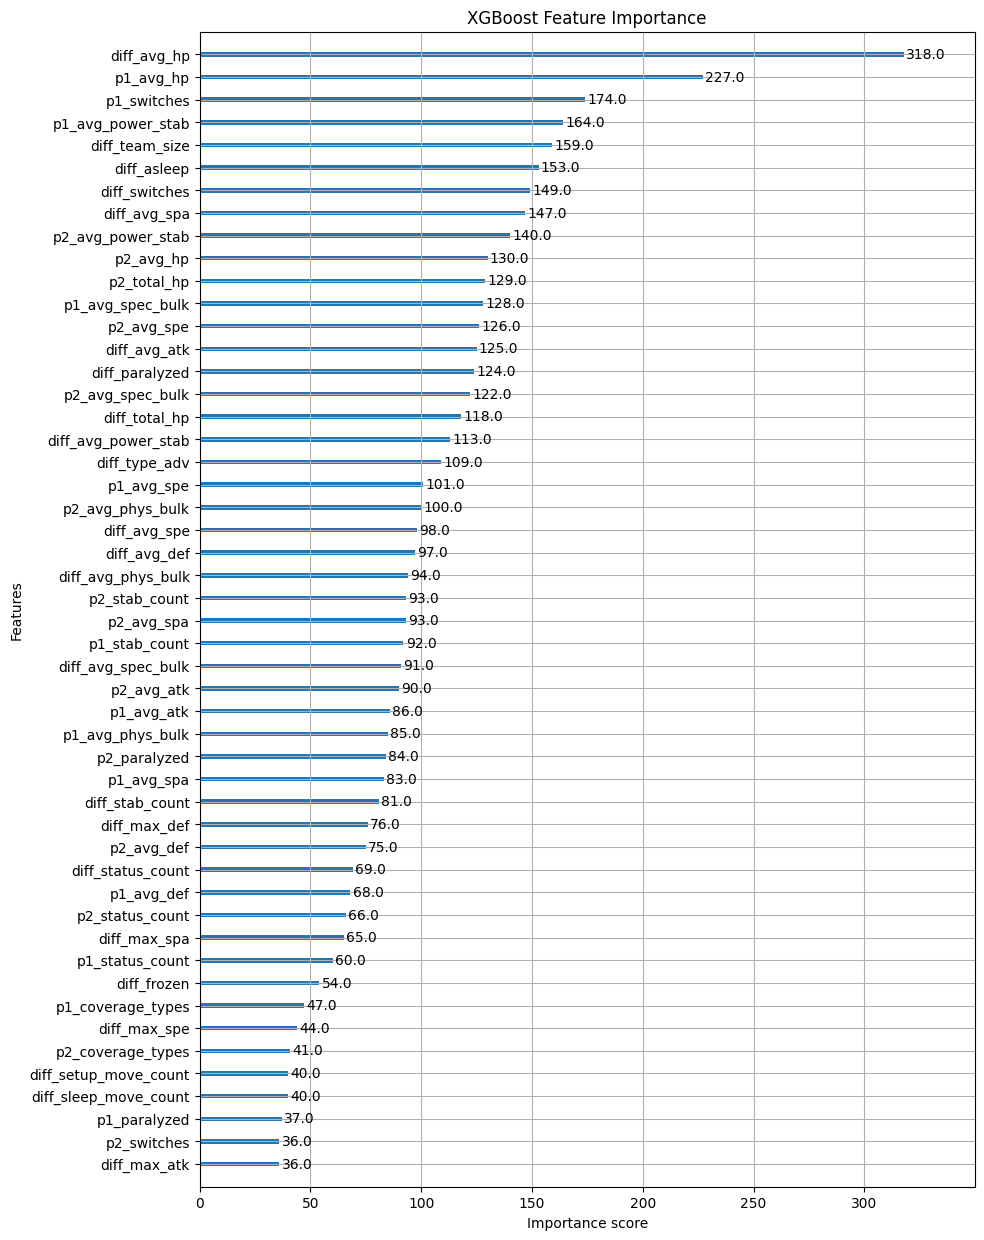

In [33]:
# --- Plot XGBoost Feature Importance ---
plt.figure(figsize=(10, 15))
plot_importance(final_model_xgb, max_num_features=50, ax=plt.gca(), title="XGBoost Feature Importance")
plt.show()

### Model 2: LightGBM (LGBM)

In [34]:
print("\n--- Training LightGBM model... ---")
# Initialize LightGBM Classifier with tuned parameters
final_model_lgbm = LGBMClassifier(
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1,
    subsample=0.8,
    colsample_bytree=0.8
)

# Train LightGBM model
final_model_lgbm.fit(X, y)
print("LightGBM model trained.")


--- Training LightGBM model... ---
[LightGBM] [Info] Number of positive: 5000, number of negative: 5000
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7828
[LightGBM] [Info] Number of data points in the train set: 10000, number of used features: 82
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
LightGBM model trained.


### Model 3: CatBoost

In [35]:
print("\n--- Training CatBoost model... ---")
# Initialize CatBoost Classifier with tuned parameters
final_model_cat = CatBoostClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_seed=42,
    verbose=0,
    thread_count=-1
)

# Train CatBoost model
final_model_cat.fit(X, y)
print("CatBoost model trained.")


--- Training CatBoost model... ---
CatBoost model trained.


# 4. Build submission file

In [ ]:
print("Generating predictions from all models...")
# We predict the probability of class 1 (p1_won)
probs_xgb = final_model_xgb.predict_proba(X_test)[:, 1]
probs_lgbm = final_model_lgbm.predict_proba(X_test)[:, 1]
probs_cat = final_model_cat.predict_proba(X_test)[:, 1]

# Blend the probabilities for establishing final predictions
blended_probs = (probs_xgb + probs_lgbm + probs_cat) / 3.0

# Convert blended probabilities to final predictions with threshold at 0.5
final_predictions = (blended_probs > 0.5)

# Convert predictions to boolean for submission
test_predictions_bool = final_predictions.astype(bool)

# Create submission DataFrame
submission_df = pd.DataFrame({
    "battle_id": df_test_features["battle_id"],
    "player_won": test_predictions_bool
})

# Save to CSV
submission_df.to_csv("submission.csv", index=False)

print("\n A blend of XGBoost, LightGBM, and CatBoost 'submission.csv' file created successfully.")
print(submission_df.head())


--- Generating predictions from all models... ---

 A blend of XGBoost, LightGBM, and CatBoost 'submission.csv' file created successfully.
   battle_id  player_won
0          0       False
1          1        True
2          2        True
3          3        True
4          4        True
